#### Data Loading

In [148]:
#All necessary package
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn  
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.colors as colors
from xgboost import XGBRegressor

In [149]:
#Load data 
df = pd.read_csv("kc_house_data.csv")
df = df[['price', 'grade', 'bedrooms', 'bathrooms', 'sqft_lot', 'yr_built', 'lat', 'long']]

In [150]:
#Remove by [Q3 + 1.5 * IQR, Q1 - 1.5 * IQR]
m = df.shape


for i in [0,2,4]: #price bedroom sqft_lot
    Q3 = df.iloc[:,i].quantile(0.75)
    Q1 = df.iloc[:,i].quantile(0.25)
    IQR = Q3 - Q1 
    uf = Q3 + 1.52 * IQR
    lb = Q1 - 1.25 * IQR

    blean = (df.iloc[:,i] < uf) & (df.iloc[:,i] > lb) 
    df = df[(blean)]
    
df


,price,grade,bedrooms,bathrooms,sqft_lot,yr_built,lat,long
0,221900.0,7,3,1.00,5650,1955,47.5112,-122.257
1,538000.0,7,3,2.25,7242,1951,47.7210,-122.319
2,180000.0,6,2,1.00,10000,1933,47.7379,-122.233
3,604000.0,7,4,3.00,5000,1965,47.5208,-122.393
4,510000.0,8,3,2.00,8080,1987,47.6168,-122.045
...,...,...,...,...,...,...,...,...
21608,360000.0,8,3,2.50,1131,2009,47.6993,-122.346
21609,400000.0,8,4,2.50,5813,2014,47.5107,-122.362
21610,402101.0,7,2,0.75,1350,2009,47.5944,-122.299
21611,400000.0,8,3,2.50,2388,2004,47.5345,-122.069


#### Visualization

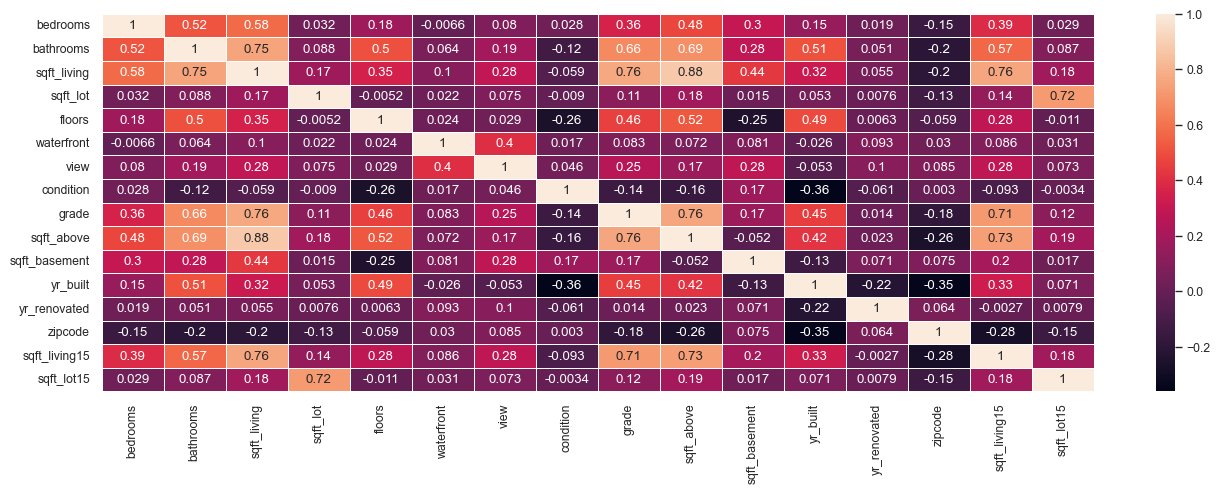

In [151]:
#Heat Map
# Visualisation regarding long and lat

data = pd.read_csv("kc_house_data.csv")
data = data.drop(['id','price','lat', 'long'],axis=1)
##NOTICE: Data is only used here. Model training use df!!!!


corr_matrix = data.corr()
plt.figure(figsize = (16,5))
seaborn.heatmap(corr_matrix, annot=True,linewidths=.5)
plt.show()

Text(0, 0.5, 'Price')

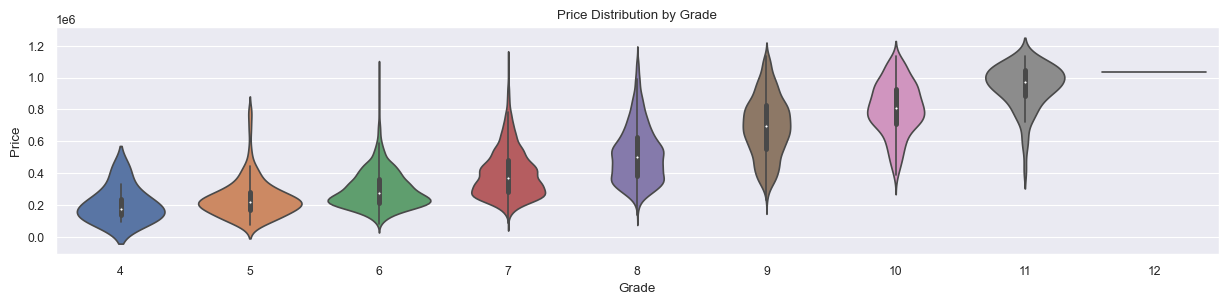

In [152]:
#slim box plot
seaborn.set_theme()
seaborn.set_context("paper")

fig, ax = plt.subplots(figsize=(15,3))
plt.title("Price Distribution by Grade")
seaborn.violinplot(x = df.grade, 
                y = df.price
                )

plt.xlabel("Grade")
plt.ylabel("Price")

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

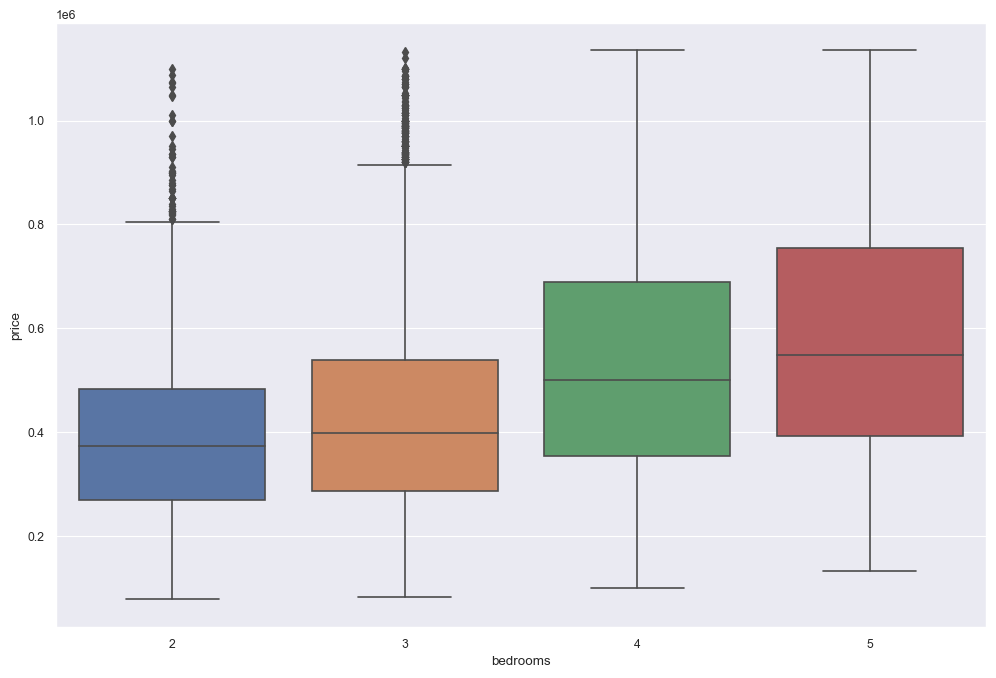

In [153]:
#Bedroom vs price
plt.figure(figsize = (12,8))
seaborn.boxplot(x='bedrooms',y='price',data=df)

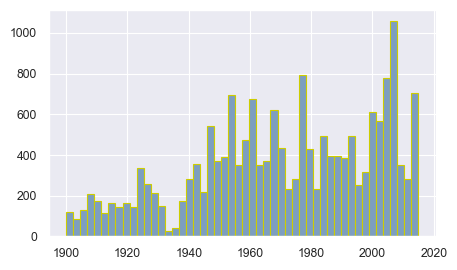

In [154]:
#Year Built vs price
df['yr_built'].hist(color = "#7D9EC0", ec="#CDCD00", bins = 50)
plt.show()

/var/folders/1x/7_p6c8r93w3g0rphpshl911c0000gn/T/ipykernel_52275/819679457.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


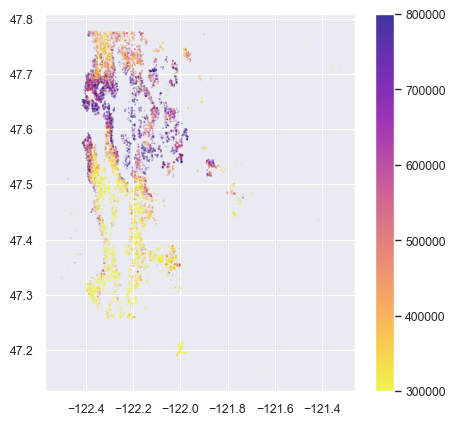

In [155]:
#Map
def visualise(df, vmin, vmax):
    
    df_sorted = df.sort_values(by='price')
    x = df_sorted['long']
    y = df_sorted['lat']
    c = df_sorted['price'] 

    plt.rcParams['figure.figsize'] = [5, 5]
    plt.rcParams['figure.dpi'] = 100 

    plt.scatter(x, y, s=0.01, c=c, cmap='plasma_r', 
                norm=colors.Normalize(vmin=vmin,vmax=vmax), alpha=0.8)
    plt.colorbar()
    plt.show()
    
visualise(df, 300000, 800000)

##### Model Training

In [156]:
#Test train split
###Divide dataset into training set(80%), test set(20%)
labels = df['price']
features = df.drop(['price'],axis=1)

x_train , x_test , y_train , y_test = train_test_split(features , labels , test_size = 0.2,random_state =1234)


#### Linear regression: Base line

In [157]:
#Simple linear model
lm = LinearRegression()
lm.fit(x_train, y_train)
y_pred = lm.predict(x_train)

print('R-Squre',metrics.r2_score(y_train, y_pred))
print('rmse:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R-Squre 0.6278545961324722
rmse: 124427.98838421032


[Text(0.5, 1.0, 'Predicted vs residuals'), Text(0.5, 0, 'Residuals')]

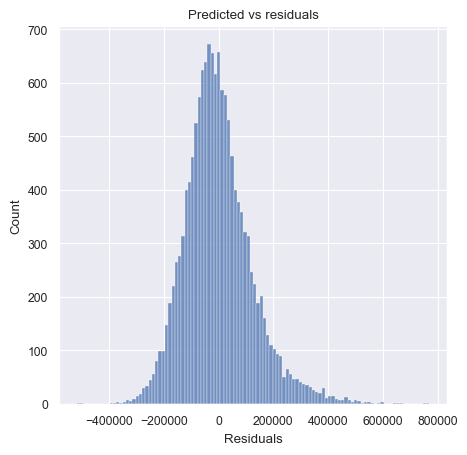

In [158]:
seaborn.histplot(y_train-y_pred).set(title="Predicted vs residuals", xlabel = "Residuals")

#### KNN

In [159]:
#Perforemance measure
from sklearn.metrics import mean_squared_error
#rmse = mean_squared_error(y_test, y_preds) ** (1/2)

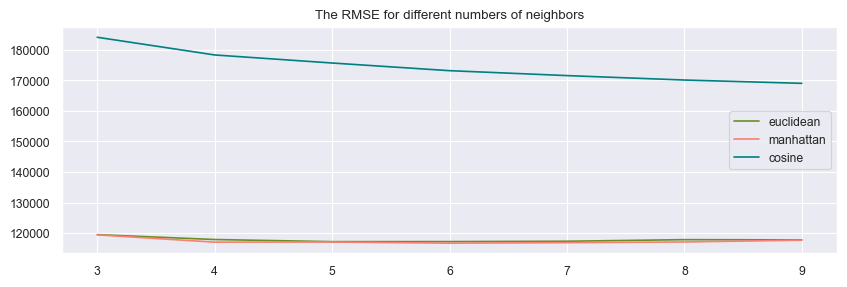

In [160]:
#compute the reasonable K
euclidean = []
manhattan = []
cosine = []

r = range(3,10)
for i in r:
    
    knn = KNeighborsRegressor(n_neighbors=i, metric='euclidean')
    knn.fit(x_train[['lat', 'long']],y_train)
    y_preds = knn.predict(x_test[['lat', 'long']])
    euclidean.append(mean_squared_error(y_test, y_preds)** (1/2))
    
    
    knn = KNeighborsRegressor(n_neighbors=i, metric='manhattan')
    knn.fit(x_train[['lat', 'long']],y_train)
    y_preds = knn.predict(x_test[['lat', 'long']])
    manhattan.append(mean_squared_error(y_test, y_preds)** (1/2))
    
    
    knn = KNeighborsRegressor(n_neighbors=i, metric='cosine')
    knn.fit(x_train[['lat', 'long']],y_train)
    y_preds = knn.predict(x_test[['lat', 'long']])
    cosine.append(mean_squared_error(y_test, y_preds)** (1/2))
    
euclidean = np.array(euclidean) 
manhattan = np.array(manhattan) 
cosine = np.array(cosine) 


plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 
plt.plot(r,euclidean,label='euclidean',color='#6B8E23')
plt.plot(r,manhattan,label='manhattan',color='#FA8072')
plt.plot(r,cosine,label='cosine',color='#008080')
plt.legend()
plt.title('The RMSE for different numbers of neighbors')
plt.gca().set_xticks(r)
plt.show()

In [161]:
#KNN distance metric using only log and lat 
r = range(1, 20) #number of NN   "chebyshev","mahalanobis"
rmse_matrix = np.zeros((9,19))
rmse_matrix_train = np.zeros((9,19))


for i in list([1,2,3,4,5,6,7,8]):
    for j in r:
        knn = KNeighborsRegressor(n_neighbors=j, metric="minkowski", p = i)
        knn.fit(x_train[['lat', 'long']],y_train)
        y_train_preds = knn.predict(x_train[['lat', 'long']])
        y_preds = knn.predict(x_test[['lat', 'long']])
        rmse_matrix[i-1,j-1] = mean_squared_error(y_test, y_preds)** (1/2)
        rmse_matrix_train[i-1,j-1] = mean_squared_error(y_train, y_train_preds)** (1/2)

for i in list([[8,'chebyshev']]):
    for j in r:
        knn = KNeighborsRegressor(n_neighbors=j, metric = i[1])
        knn.fit(x_train[['lat', 'long']],y_train)
        y_train_preds = knn.predict(x_train[['lat', 'long']])
        y_train_MSE = knn.predict(x_train[['lat', 'long']])
        y_preds = knn.predict(x_test[['lat', 'long']])
        rmse_matrix[i[0],j-1] = mean_squared_error(y_test, y_preds)** (1/2)
        rmse_matrix_train[i[0],j-1] = mean_squared_error(y_train, y_train_preds)** (1/2)
       
       

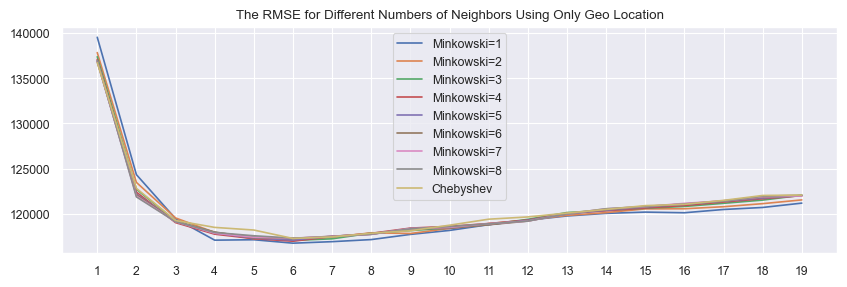

116734.03914542917


In [162]:

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 
plt.plot(r,rmse_matrix[0],label='Minkowski=1')
plt.plot(r,rmse_matrix[1],label='Minkowski=2')
plt.plot(r,rmse_matrix[2],label='Minkowski=3')
plt.plot(r,rmse_matrix[3],label='Minkowski=4')
plt.plot(r,rmse_matrix[4],label='Minkowski=5')
plt.plot(r,rmse_matrix[5],label='Minkowski=6')
plt.plot(r,rmse_matrix[6],label='Minkowski=7')
plt.plot(r,rmse_matrix[7],label='Minkowski=8')
plt.plot(r,rmse_matrix[8],label='Chebyshev')



plt.legend()
plt.title('The RMSE for Different Numbers of Neighbors Using Only Geo Location')
plt.gca().set_xticks(r)
plt.show()

print(min(rmse_matrix[0]))
#This is the plot of TEST SET



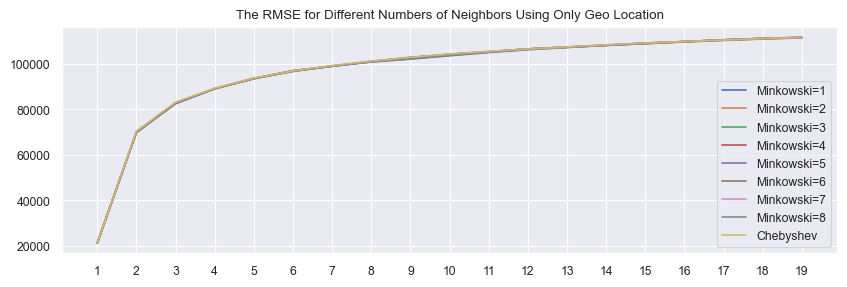

93599.54986293089


In [163]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 
plt.plot(r,rmse_matrix_train[0],label='Minkowski=1')
plt.plot(r,rmse_matrix_train[1],label='Minkowski=2')
plt.plot(r,rmse_matrix_train[2],label='Minkowski=3')
plt.plot(r,rmse_matrix_train[3],label='Minkowski=4')
plt.plot(r,rmse_matrix_train[4],label='Minkowski=5')
plt.plot(r,rmse_matrix_train[5],label='Minkowski=6')
plt.plot(r,rmse_matrix_train[6],label='Minkowski=7')
plt.plot(r,rmse_matrix_train[7],label='Minkowski=8')
plt.plot(r,rmse_matrix_train[8],label='Chebyshev')



plt.legend()
plt.title('The RMSE for Different Numbers of Neighbors Using Only Geo Location')
plt.gca().set_xticks(r)
plt.show()
#print(min(rmse_matrix[8]))
#This is the plot of TRAIN SET
print(rmse_matrix_train[0][4])

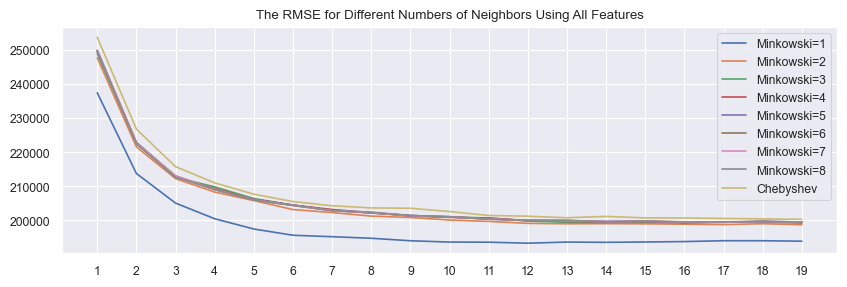

193329.84186416856


In [164]:
#KNN using all features 
r = range(1, 20) #number of NN   "chebyshev","mahalanobis"
rmse_matrix = np.zeros((9,19))
rmse_matrix_train = np.zeros((9,19))

for i in list([1,2,3,4,5,6,7,8]):
    for j in r:
        knn = KNeighborsRegressor(n_neighbors=j, metric="minkowski", p = i)
        knn.fit(x_train,y_train)
        y_train_preds = knn.predict(x_train)
        y_preds = knn.predict(x_test)
        rmse_matrix[i-1,j-1] = mean_squared_error(y_test, y_preds) ** (1/2)
        rmse_matrix_train[i-1,j-1] = mean_squared_error(y_train, y_train_preds)** (1/2)


for i in list([[8,'chebyshev']]):
    for j in r:
        knn = KNeighborsRegressor(n_neighbors=j, metric = i[1])
        knn.fit(x_train,y_train)
        y_preds = knn.predict(x_test)
        y_train_preds = knn.predict(x_train)
        rmse_matrix[i[0],j-1] = mean_squared_error(y_test, y_preds) ** (1/2)
        rmse_matrix_train[i[0],j-1] = mean_squared_error(y_train, y_train_preds)** (1/2)

#plot MSE 

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 
plt.plot(r,rmse_matrix[0],label='Minkowski=1')
plt.plot(r,rmse_matrix[1],label='Minkowski=2')
plt.plot(r,rmse_matrix[2],label='Minkowski=3')
plt.plot(r,rmse_matrix[3],label='Minkowski=4')
plt.plot(r,rmse_matrix[4],label='Minkowski=5')
plt.plot(r,rmse_matrix[5],label='Minkowski=6')
plt.plot(r,rmse_matrix[6],label='Minkowski=7')
plt.plot(r,rmse_matrix[7],label='Minkowski=8')
plt.plot(r,rmse_matrix[8],label='Chebyshev')



plt.legend()
plt.title('The RMSE for Different Numbers of Neighbors Using All Features')
plt.gca().set_xticks(r)
plt.show()

print(min(rmse_matrix[0]))
#This is the plot of TEST

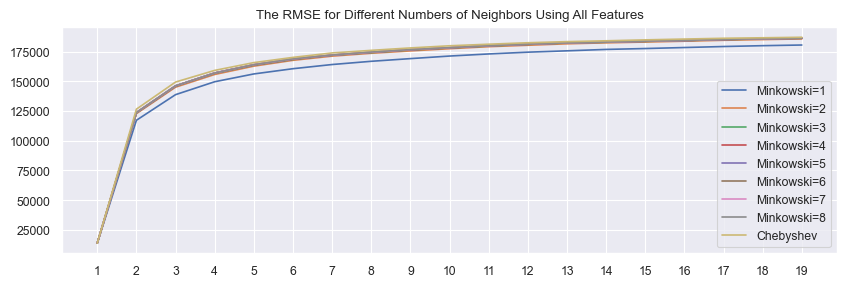

172962.1949316725


In [165]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100 
plt.plot(r,rmse_matrix_train[0],label='Minkowski=1')
plt.plot(r,rmse_matrix_train[1],label='Minkowski=2')
plt.plot(r,rmse_matrix_train[2],label='Minkowski=3')
plt.plot(r,rmse_matrix_train[3],label='Minkowski=4')
plt.plot(r,rmse_matrix_train[4],label='Minkowski=5')
plt.plot(r,rmse_matrix_train[5],label='Minkowski=6')
plt.plot(r,rmse_matrix_train[6],label='Minkowski=7')
plt.plot(r,rmse_matrix_train[7],label='Minkowski=8')
plt.plot(r,rmse_matrix_train[8],label='Chebyshev')



plt.legend()
plt.title('The RMSE for Different Numbers of Neighbors Using All Features')
plt.gca().set_xticks(r)
plt.show()
#This is the plot of TRAIN
print(rmse_matrix_train[0][10])

##### XG BOOst 

In [166]:
#boosting accuracy
from xgboost import XGBRegressor
regboost=XGBRegressor(learning_rate=0.5, max_depth=4, n_estimators=500)
regboost.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [167]:
yboost=regboost.predict(x_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score3= r2_score(y_test,yboost)
score4=mean_squared_error(y_test,yboost)
print("Score with XGBoost ",score3)
print("Score with mse ",score4)

Score with XGBoost  0.8249799633913636
Score with mse  7539964752.107941


#### Polynomial Regression

In [168]:
reg = LinearRegression()
reg.fit(x_train,y_train)
y_preds = reg.predict(x_test)

[123829.05139212932]
[124427.98838421033]
[123829.05139212932, 117304.21465155989]
[124427.98838421033, 115555.17913147467]
[123829.05139212932, 117304.21465155989, 107481.38586859398]
[124427.98838421033, 115555.17913147467, 106004.69868633313]
[123829.05139212932, 117304.21465155989, 107481.38586859398, 109791.70721819585]
[124427.98838421033, 115555.17913147467, 106004.69868633313, 106634.15635080534]
[123829.05139212932, 117304.21465155989, 107481.38586859398, 109791.70721819585, 110345.16433312761]
[124427.98838421033, 115555.17913147467, 106004.69868633313, 106634.15635080534, 106055.14581301811]


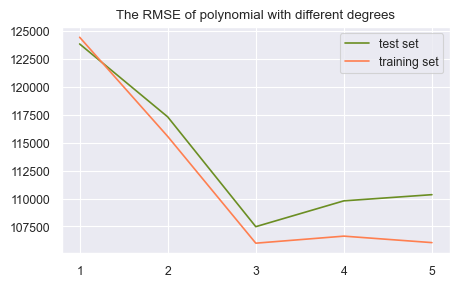

In [169]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
poly_degree = []
poly_train = []
r = range(1,6)
for i in r:
    poly_reg = PolynomialFeatures(degree = i)
    x_poly = poly_reg.fit_transform(x_train)
    pol_reg = LinearRegression()
    pol_reg.fit(x_poly, y_train)
    pol_y_preds = pol_reg.predict(poly_reg.fit_transform(x_test))
    pol_y_preds_train = pol_reg.predict(poly_reg.fit_transform(x_train))
    poly_degree.append(mean_squared_error(y_test, pol_y_preds)** (1/2))
    poly_train.append(mean_squared_error(y_train, pol_y_preds_train)** (1/2))
    print(poly_degree)
    print(poly_train)

poly_degree = np.array(poly_degree) 
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100 
l1 = plt.plot(r,poly_degree,label='test set',color='#6B8E23')
l2 = plt.plot(r,poly_train, label= 'training set', color='#FF7F50')
plt.legend()
plt.title('The RMSE of polynomial with different degrees')
plt.gca().set_xticks(r)
plt.show()